<a href="https://colab.research.google.com/github/hnguyen8/gans/blob/main/DCGAN_sim_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
Created by Hien Nguyen on May 2022

**TASK**

This project generates realistic looking 256x256-grayscale heat-simulation-image with a DCGAN using the 1K dataset as input.

Outputs for analysis:
- 4 fake images (.png) every 10 epochs, for visual comparision
- 1 numpy array (.hdf5) every 10 epochs, for statistics analysis
- Weights of current model (3 checkpoint files), which are replaced every 100 epochs. Older versions of checkpoint may be deleted after 30 days or after 100 versions are stored. 



**References**

Losely based on

[DCGAN to generate face images](https://keras.io/examples/generative/dcgan_overriding_train_step/)


**Prepare resources**

In [ ]:
# Authorize Goo
from google.colab import auth 
auth.authenticate_user()

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()            # checks the current hardware that Google has assigned for us 

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4466646750364144126
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6675011817963808898
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')            # Connect to Google Drive

Mounted at /content/gdrive


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown
import pickle
import h5py
import cv2
from tqdm import tqdm


Create a dataset from our folder, and rescale the images to the [0-1] range:

Found 1008 files belonging to 1 classes.


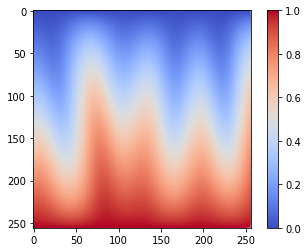

In [ ]:
my_batch_size = 32
dataset = keras.preprocessing.image_dataset_from_directory(
    f'/content/gdrive/My Drive/data/DCGAN_Sim2/Training', label_mode=None, image_size=(256,256),
    batch_size=my_batch_size,shuffle =True,color_mode="grayscale")

dataset = dataset.map(lambda x: x/255)

# Show 1 real image
count = 0
for batch in dataset:
  for x in batch:
    if count<= 0:
      plt.imshow(x[:,:,0],cmap = "coolwarm")
      plt.colorbar()
      plt.show()
      count+=1

**DCGAN model**


Build the discriminator and generator

In [ ]:
def discriminator_model():
    model = tf.keras.Sequential()
        
    #add Gaussian noise to prevent Discriminator overfitting
    model.add(layers.GaussianNoise(0.2, input_shape = [256, 256, 1]))
    
    #256x256x3 Image
    model.add(layers.Conv2D(filters = 8, kernel_size = 3, padding = 'same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.AveragePooling2D())
    
    #128x128x8
    model.add(layers.Conv2D(filters = 16, kernel_size = 3, padding = 'same'))
    model.add(layers.BatchNormalization(momentum = 0.7))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.AveragePooling2D())
    
    #64x64x16
    model.add(layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same'))
    model.add(layers.BatchNormalization(momentum = 0.7))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.AveragePooling2D())
    
    #32x32x32
    model.add(layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same'))
    model.add(layers.BatchNormalization(momentum = 0.7))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.AveragePooling2D())
    
    #16x16x64
    model.add(layers.Conv2D(filters = 128, kernel_size = 3, padding = 'same'))
    model.add(layers.BatchNormalization(momentum = 0.7))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.AveragePooling2D())
    
    #8x8x128
    model.add(layers.Conv2D(filters = 256, kernel_size = 3, padding = 'same'))
    model.add(layers.BatchNormalization(momentum = 0.7))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.AveragePooling2D())
    
    #4x4x256
    model.add(layers.Flatten())
    
    #256
    model.add(layers.Dense(128))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Dense(1, activation = 'sigmoid'))
    
    return model

# Declares the discriminator
discriminator = discriminator_model()

discriminator.summary()

latent_dim = 4096

def generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Reshape(target_shape = [1, 1, 4096], input_shape = [4096]))
    assert model.output_shape == (None, 1, 1, 4096)
        
    model.add(layers.Conv2DTranspose(filters = 256, kernel_size = 4))
    model.add(layers.Activation('relu'))
    assert model.output_shape == (None, 4, 4, 256)
    
    model.add(layers.Conv2D(filters = 256, kernel_size = 4, padding = 'same'))
    model.add(layers.BatchNormalization(momentum = 0.7))
    model.add(layers.Activation('relu'))
    model.add(layers.UpSampling2D())
    assert model.output_shape == (None, 8, 8, 256)
    
    model.add(layers.Conv2D(filters = 128, kernel_size = 4, padding = 'same'))
    model.add(layers.BatchNormalization(momentum = 0.7))
    model.add(layers.Activation('relu'))
    model.add(layers.UpSampling2D())
    assert model.output_shape == (None, 16, 16, 128)
    
    model.add(layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same'))
    model.add(layers.BatchNormalization(momentum = 0.7))
    model.add(layers.Activation('relu'))
    model.add(layers.UpSampling2D())
    assert model.output_shape == (None, 32, 32, 64)
    
    model.add(layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same'))
    model.add(layers.BatchNormalization(momentum = 0.7))
    model.add(layers.Activation('relu'))
    model.add(layers.UpSampling2D())
    assert model.output_shape == (None, 64, 64, 32)
    
    model.add(layers.Conv2D(filters = 16, kernel_size = 3, padding = 'same'))
    model.add(layers.BatchNormalization(momentum = 0.7))
    model.add(layers.Activation('relu'))
    model.add(layers.UpSampling2D())
    assert model.output_shape == (None, 128, 128, 16)
    
    model.add(layers.Conv2D(filters = 8, kernel_size = 3, padding = 'same'))
    model.add(layers.Activation('relu'))
    model.add(layers.UpSampling2D())
    assert model.output_shape == (None, 256, 256, 8)
    
    model.add(layers.Conv2D(filters = 1, kernel_size = 3, padding = 'same'))
    model.add(layers.Activation('tanh'))
    assert model.output_shape == (None, 256, 256, 1)
    
    return model

# declares the generator
generator = generator_model()
generator.summary()



**Build the DCGAN model, overriding train_step**

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")


    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
       
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),   
        }

Create a  **GANMonitor callback** that:


*   saves 4 fake images (.png) after every 10 epochs
*   saves 1 fake array (.hdf5) after every 10 epochs




In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

   
    def on_epoch_end(self, epoch, logs={}):
      if (epoch) % 10 == 0:
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim),seed=1) 
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        xyz = generated_images.numpy()
        the_array = []
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(xyz[i])
            the_array.append(img)
            
        plt.figure(figsize=(10,10)) # specifying the overall grid size
        for i in range(4):
            plt.subplot(2,2,i+1)    # the number of images in the grid is 2*2
            #plt.axis('off')
            plt.imshow(the_array[i],cmap = "coolwarm")
        #plt.gcf().set_dpi(300)
        plt.title('epoch_%03d' % epoch)
        plt.savefig(f'/content/gdrive/My Drive/data/DCGAN_Sim2/Generated/epoch_%03d.png' % epoch)
        plt.close()

        f = h5py.File("/content/gdrive/My Drive/data/DCGAN_Sim2/Generated/hdf5/epoch_%03d.hdf5" % epoch, "w")
        f.create_dataset("init", data=xyz[0])
        f.close()

Compile the DCGAN model

In [ ]:
def make_model():
  gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
  gan.compile(
      d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
      g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
      loss_fn=keras.losses.BinaryCrossentropy()
  )
  return gan

Create a second callback that saves checkpoints every 100 epochs.

In [ ]:
checkpoint_path = "/content/gdrive/My Drive/data/DCGAN_Sim2/Generated/checkpoint/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
latest = tf.train.latest_checkpoint(checkpoint_dir)

# Create a callback that saves the model's weights every 100 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_freq = my_batch_size*100,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 monitor = 'g_loss',
                                              save_best_only=False)


Start training (or resume training if previous checkpoint exists) 

In [ ]:
# Create a basic model instance
#model = make_model()

# Load weights, if previous checkpoint exists, else skip this
#model.load_weights( latest)

start =2000
end = 3001
# Train the model with two callbacks
history = model.fit(dataset, initial_epoch=start  , epochs=end, callbacks=[GANMonitor(num_img=4, latent_dim=latent_dim), cp_callback])

Epoch 2001/3001
32/32 [==============================] - 5s 144ms/step - d_loss: 0.0741 - g_loss: 4.8134
Epoch 2002/3001
32/32 [==============================] - 4s 108ms/step - d_loss: 0.0692 - g_loss: 5.2782
Epoch 2003/3001
32/32 [==============================] - 4s 94ms/step - d_loss: 0.0985 - g_loss: 5.7030
Epoch 2004/3001
32/32 [==============================] - 4s 97ms/step - d_loss: 0.0834 - g_loss: 6.4879
Epoch 2005/3001
32/32 [==============================] - 4s 97ms/step - d_loss: 0.1102 - g_loss: 4.6425
Epoch 2006/3001
32/32 [==============================] - 4s 96ms/step - d_loss: 0.0902 - g_loss: 5.4487
Epoch 2007/3001
32/32 [==============================] - 4s 95ms/step - d_loss: 0.0807 - g_loss: 4.9231
Epoch 2008/3001
32/32 [==============================] - 4s 96ms/step - d_loss: 0.0804 - g_loss: 4.5680
Epoch 2009/3001
32/32 [==============================] - 4s 92ms/step - d_loss: 0.0635 - g_loss: 5.2948
Epoch 2010/3001
32/32 [==============================] - 4s 95

Show a fake image from the current model:

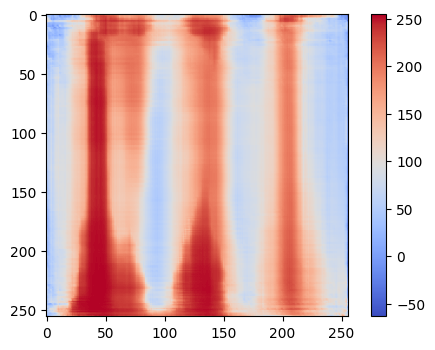

In [ ]:
# create random vectors
n = 1
random_latent_vectors = tf.random.normal(shape=(n,4096),seed = 555555555555555)

# generate image in EagerTensor 
generated_images = model.generator(random_latent_vectors)

# EagerTensor --> arrays 
generated_images = generated_images.numpy()*255

# Show generated images
img = keras.preprocessing.image.array_to_img(generated_images[0])
plt.rcParams['figure.dpi'] = 100
#plt.imshow(img1,cmap = "binary")
plt.imshow(generated_images[0,:,:,0],cmap = "coolwarm")
plt.colorbar()
plt.show()